## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import json
sns.set_theme('notebook')


sns.set_theme('notebook')

## Image classification dataset

In [ ]:
# Paths to the dataset
dataset_path = "./data/animal_classification_data/animals/animals"
labels_file = "./data/animal_classification_data/name of the animals.txt"

In [38]:
# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [39]:
# Display the first few animal names
animal_names[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

In [40]:
# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

fig = px.bar(animal_counts_df, 
             x='Animal', 
             y='Count', 
             title='Distribution of Animal Classes', color="Count")

fig.update_layout(coloraxis_showscale=False)

fig.show()

The dataset contains 90 classes, each with 60 photos. To train the model, we need to use image augmentation.

## NER dataset 

In [ ]:
# Loading a dataset 
with open('./animal_ner_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert the dataset to a DataFrame for easier handling
df = pd.DataFrame(data)

In [44]:
df.head()

,sentence,entities
0,A bull sable antelope among the trees in the A...,"[{'start': 13, 'end': 21, 'label': 'ANIMAL'}]"
1,Antelope vary greatly in size.,"[{'start': 0, 'end': 8, 'label': 'ANIMAL'}]"
2,"For example, a male common eland can measure 1...","[{'start': 114, 'end': 122, 'label': 'ANIMAL'}]"
3,The chiru or Tibetan antelope is hunted for it...,"[{'start': 21, 'end': 29, 'label': 'ANIMAL'}]"
4,Since the fur can only be removed from dead an...,"[{'start': 114, 'end': 122, 'label': 'ANIMAL'}]"


#### Number of samples (sentences)

In [45]:
print(f"Total number of sentences: {len(df)}")

Total number of sentences: 53126


#### Number of unique entities

In [46]:
all_entities = [entity['label'] for sublist in df['entities'] for entity in sublist]
unique_entities = set(all_entities)
print(f"Unique entities: {len(unique_entities)} ({', '.join(unique_entities)})")

Unique entities: 1 (ANIMAL)


#### Duplicates in sentences

In [47]:
duplicate_sentences = df[df.duplicated(subset=["sentence"])]
print(f"Duplicate Sentences ({len(duplicate_sentences)}):")
print(duplicate_sentences[['sentence']])

Duplicate Sentences (29668):
                                                sentence
708                                                Bats.
749             Bat wing sensors support flight control.
801                      Bat Conservation International.
822                      Bat Conservation International.
834                      Bat Conservation International.
...                                                  ...
53121  Experimental evidence that stripes do not cool...
53122  In cultures outside of its range, the zebra ha...
53123  The film Racing Stripes features a captive zeb...
53124  Zebras have been featured as characters in ani...
53125                         Domestication of the horse

[29668 rows x 1 columns]


In [48]:
df_nd = df.drop_duplicates(subset=['sentence'])
df_nd.shape

(23458, 2)

#### Sentences with Missing Entities

In [49]:
missing_entities = df_nd[df_nd['entities'].apply(len) == 0]
print(f"Sentences with Missing Entities ({len(missing_entities)}):")
print(missing_entities[['sentence']])

Sentences with Missing Entities (0):
Empty DataFrame
Columns: [sentence]
Index: []


#### Entity span mismatches (checking if entity span exceeds sentence length)

In [50]:
def check_entity_span(row):
    sentence_length = len(row['sentence'])
    for entity in row['entities']:
        start, end = entity['start'], entity['end']
        if start > sentence_length or end > sentence_length:
            return True
    return False

mismatched_spans = df_nd[df_nd.apply(check_entity_span, axis=1)]
print(f"Sentences with Mismatched Entity Spans ({len(mismatched_spans)}):")
print(mismatched_spans[['sentence']])

Sentences with Mismatched Entity Spans (0):
Empty DataFrame
Columns: [sentence]
Index: []


#### Entity label consistency (e.g., duplicate entities with the same span)

In [51]:
df_nd.iloc[35]['entities']

[{'start': 97, 'end': 105, 'label': 'ANIMAL'},
 {'start': 7, 'end': 11, 'label': 'ANIMAL'},
 {'start': 7, 'end': 11, 'label': 'ANIMAL'}]

In [52]:
def check_duplicate_labels(entities):
    seen = set()
    for entity in entities:
        if (entity['start'], entity['end'], entity['label']) in seen:
            return True
        seen.add((entity['start'], entity['end'], entity['label']))
    return False

duplicate_entities = df_nd[df_nd['entities'].apply(check_duplicate_labels)]
print(f"Sentences with Duplicate Entity Labels ({len(duplicate_entities)}):")

Sentences with Duplicate Entity Labels (2072):


In [53]:
duplicate_entities.head()

,sentence,entities
35,"Unlike deer, in which the males sport elaborat...","[{'start': 97, 'end': 105, 'label': 'ANIMAL'},..."
49,"Antelopes do not form a monophyletic group, as...","[{'start': 138, 'end': 143, 'label': 'ANIMAL'}..."
50,"Although antelope are sometimes referred to, a...","[{'start': 9, 'end': 17, 'label': 'ANIMAL'}, {..."
51,While antelope are found in abundance in Afric...,"[{'start': 6, 'end': 14, 'label': 'ANIMAL'}, {..."
52,"By comparison, numerous deer species are usual...","[{'start': 96, 'end': 104, 'label': 'ANIMAL'},..."


In [18]:
df_nd.iloc[35]['entities']

[{'start': 97, 'end': 105, 'label': 'ANIMAL'},
 {'start': 7, 'end': 11, 'label': 'ANIMAL'},
 {'start': 7, 'end': 11, 'label': 'ANIMAL'}]

In [19]:
def remove_duplicate_labels(entities):
    seen = set()
    unique_entities = []
    
    for entity in entities:
        entity_tuple = (entity['start'], entity['end'], entity['label'])
        if entity_tuple not in seen:
            unique_entities.append(entity)
            seen.add(entity_tuple)
    
    return unique_entities

df_nd.loc[:, 'entities'] = df_nd['entities'].apply(remove_duplicate_labels)

In [20]:
df_nd.iloc[35]['entities']

[{'start': 97, 'end': 105, 'label': 'ANIMAL'},
 {'start': 7, 'end': 11, 'label': 'ANIMAL'}]

#### Empty sentences

In [21]:
empty_sentences = df_nd[df_nd['sentence'].str.strip() == ""]
print(f"Empty Sentences ({len(empty_sentences)}):")
print(empty_sentences[['sentence']])

Empty Sentences (0):
Empty DataFrame
Columns: [sentence]
Index: []


#### Number of entities per sentence (distribution)

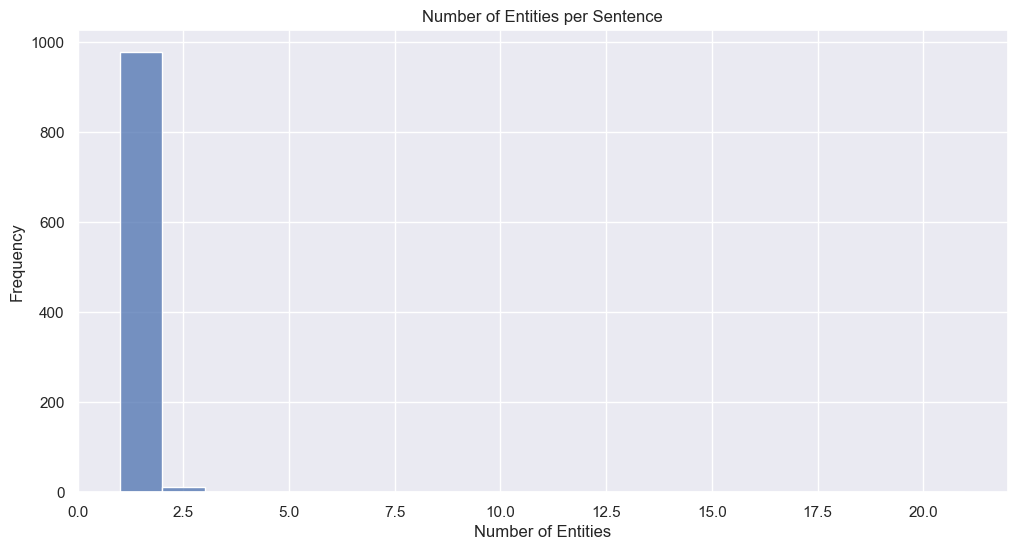

In [22]:
entities_per_sentence = df_nd['entities'].apply(len)

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram for number of entities per sentence
sns.histplot(
    np.log(entities_per_sentence), 
    bins=range(1, int(entities_per_sentence.max())+1), 
    kde=False)

plt.title('Number of Entities per Sentence')
plt.xlabel('Number of Entities')
plt.ylabel('Frequency')
plt.show()

In [23]:
entities_per_sentence.value_counts().sort_index()

entities
1     19325
2      3143
3       654
4       222
5        60
6        27
7        15
8         8
9         3
21        1
Name: count, dtype: int64

#### Average sentence length (in words and characters)

In [33]:
df_nd.loc[:, 'sentence_length_words'] = df_nd['sentence'].apply(lambda x: len(x.split()))
df_nd.loc[:, 'sentence_length_chars'] = df_nd['sentence'].apply(lambda x: len(x))
avg_sentence_length_words = df_nd['sentence_length_words'].mean()
avg_sentence_length_chars = df_nd['sentence_length_chars'].mean()

print(f"Average sentence length (words): {avg_sentence_length_words:.2f}")
print(f"Average sentence length (characters): {avg_sentence_length_chars:.2f}")

Average sentence length (words): 15.79
Average sentence length (characters): 99.45


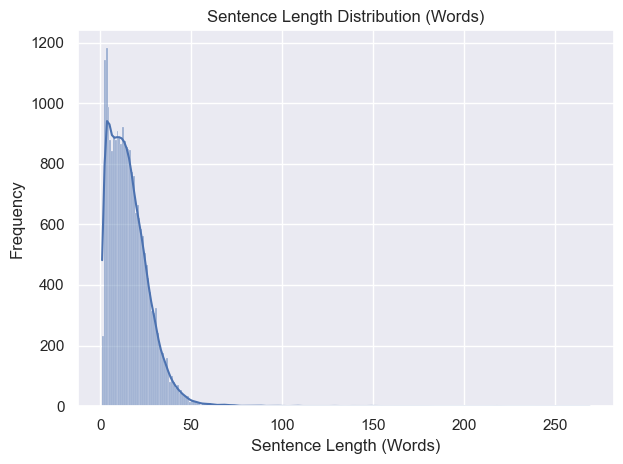

In [25]:
# Sentence length distribution
sns.histplot(df_nd['sentence_length_words'], bins=range(1, int(df_nd['sentence_length_words'].max())+1), kde=True)
plt.title('Sentence Length Distribution (Words)')
plt.xlabel('Sentence Length (Words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [26]:
df_nd.describe()

,sentence_length_words,sentence_length_chars
count,23458.000000,23458.000000
mean,15.794910,99.448546
std,12.439779,83.970441
min,1.000000,2.000000
25%,7.000000,46.000000
50%,14.000000,86.000000
75%,22.000000,134.000000
max,269.000000,2211.000000


#### Removing extra long sentences

In [ ]:
q = df_nd['sentence_length_words'].quantile(0.99)
df_new = df_nd[df_nd['sentence_length_words'] < q]

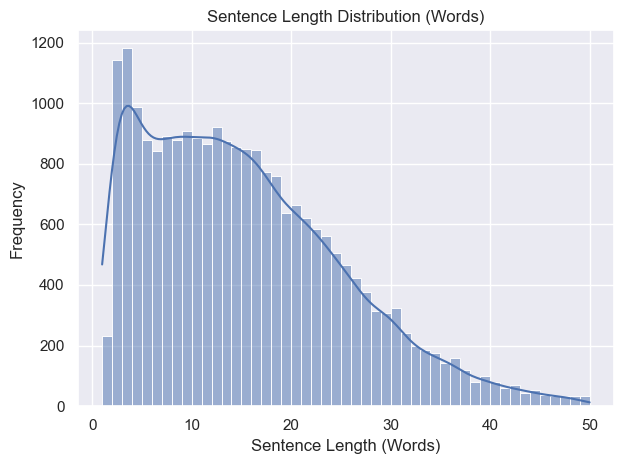

In [ ]:
# Sentence length distribution
sns.histplot(df_new['sentence_length_words'], 
             bins=range(1, int(df_new['sentence_length_words'].max())+1), 
             kde=True)

plt.title('Sentence Length Distribution (Words)')
plt.xlabel('Sentence Length (Words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [29]:
df_new.describe()

,sentence_length_words,sentence_length_chars
count,23222.000000,23222.000000
mean,15.154164,94.895573
std,9.928980,61.375251
min,1.000000,2.000000
25%,7.000000,46.000000
50%,14.000000,85.000000
75%,21.000000,133.000000
max,50.000000,415.000000


In [30]:
df_new.shape

(23222, 4)

#### Saving cleaned dataset

In [31]:
dataset = df_new[['sentence', 'entities']].to_dict(orient='records')

In [32]:
output_file = './cleaned_animal_dataset.json'
with open(output_file, 'w') as f:
    json.dump(dataset, f, indent=2) 